In [ ]:
!pip install tensorflow-federated
!pip install roboflow
!pip install scikit-learn
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 108.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of tensorflow-federated to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.3/887.3 kB 52.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is still looking at multiple versions of tensorflow-federated to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance

In [ ]:
# Cell 0 — Runtime check (Colab)
import sys, platform, os, subprocess

# Basic env
print(f"Python: {sys.version.split()[0]}")
print(f"OS: {platform.platform()}")

# Torch / CUDA
try:
    import torch
    print(f"PyTorch: {torch.__version__}")
    cuda_ok = torch.cuda.is_available()
    print(f"CUDA available: {cuda_ok}")
    if cuda_ok:
        print(f"CUDA version (nvcc):")
        try:
            out = subprocess.check_output(["nvcc", "--version"], text=True)
            print("\n".join(out.strip().splitlines()[-2:]))
        except Exception as e:
            print(f"nvcc not found: {e}")
        print(f"GPU count: {torch.cuda.device_count()}")
        print(f"GPU name: {torch.cuda.get_device_name(0)}")
        print(f"cuDNN: {torch.backends.cudnn.version()}")
    else:
        print("Enable GPU: Runtime > Change runtime type > Hardware accelerator: GPU")
except Exception as e:
    print("PyTorch not installed yet. We install it in the next cell.", e)


Python: 3.12.11
OS: Linux-6.6.97+-x86_64-with-glibc2.35
PyTorch: 2.8.0+cu126
CUDA available: True
CUDA version (nvcc):
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
GPU count: 1
GPU name: Tesla T4
cuDNN: 91002


In [ ]:
pip install roboflow monai segmentation-models-pytorch pycocotools albumentations flower tensorboard matplotlib shapely

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.8/438.8 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.9 MB/s eta 0:00:00


In [ ]:
# Cell 2 — Imports, config, and reproducibility setup

import os
import random
import numpy as np
import torch

# Set seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Paths
DATA_DIR = "/content/data"
ARTIFACTS_DIR = "/content/artifacts"
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# Label mapping: background=0, then 3 tumor types
CLASS_NAMES = ["background", "glioma", "meningioma", "pituitary", "no_tumor"]

# Hyperparameters
IMAGE_SIZE = 512
BATCH_SIZE = 8
NUM_CLASSES = len(CLASS_NAMES)

print("Config ready.")
print(f"Classes: {CLASS_NAMES}")
print(f"Image size: {IMAGE_SIZE}, Batch size: {BATCH_SIZE}")


Config ready.
Classes: ['background', 'glioma', 'meningioma', 'pituitary', 'no_tumor']
Image size: 512, Batch size: 8


In [ ]:
# Cell 3 — Download dataset from Roboflow API

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="CdIaQcUxbilfCZcWn6Kk")
project = rf.workspace("tumoranalyis").project("tumoranalysis-dmnkm")
version = project.version(3)
dataset = version.download("coco-segmentation")





print("Dataset downloaded to:", dataset.location)


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to TumorAnalysis-3 in coco-segmentation:: 100%|██████████| 5915/5915 [00:00<00:00, 8172.81it/s]

Dataset downloaded to: /content/TumorAnalysis-3


In [ ]:
# Cell 4 — Inspect dataset structure and sample files

import os
from glob import glob

# Roboflow downloads under dataset.location (e.g., /content/brain-tumor-segmentation-1)
DATA_PATH = dataset.location

# Common structure: train/valid/test with COCO JSON + images
print("Dataset root:", DATA_PATH)
print("Subfolders:", os.listdir(DATA_PATH))

# Count files
train_imgs = glob(os.path.join(DATA_PATH, "train", "*.jpg"))
val_imgs   = glob(os.path.join(DATA_PATH, "valid", "*.jpg"))
test_imgs  = glob(os.path.join(DATA_PATH, "test", "*.jpg"))

print(f"Train images: {len(train_imgs)}")
print(f"Val images:   {len(val_imgs)}")
print(f"Test images:  {len(test_imgs)}")

# Peek at a sample file
print("Example train image:", train_imgs[0] if train_imgs else "None found")
print("COCO annotation file:", glob(os.path.join(DATA_PATH, "train", "_annotations.coco.json")))


Dataset root: /content/TumorAnalysis-3
Subfolders: ['README.roboflow.txt', 'train', 'test', 'README.dataset.txt', 'valid']
Train images: 5098
Val images:   559
Test images:  250
Example train image: /content/TumorAnalysis-3/train/gg-419-_jpg.rf.387c726e00b43d02a0433ee84b602649.jpg
COCO annotation file: ['/content/TumorAnalysis-3/train/_annotations.coco.json']


In [ ]:
# Cell 5 — Parse COCO annotations and build (image, mask) pairs

import json
import cv2
import numpy as np
from tqdm import tqdm
from pycocotools.coco import COCO

# Paths
train_json = os.path.join(DATA_PATH, "train", "_annotations.coco.json")
val_json   = os.path.join(DATA_PATH, "valid", "_annotations.coco.json")
test_json  = os.path.join(DATA_PATH, "test", "_annotations.coco.json")

def build_masks(json_path, subset="train"):
    out_img_dir  = os.path.join(DATA_DIR, subset, "images")
    out_mask_dir = os.path.join(DATA_DIR, subset, "masks")
    os.makedirs(out_img_dir, exist_ok=True)
    os.makedirs(out_mask_dir, exist_ok=True)

    coco = COCO(json_path)

    for img_id in tqdm(coco.imgs, desc=f"Processing {subset}"):
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(os.path.dirname(json_path), img_info["file_name"])

        # Read image
        image = cv2.imread(img_path)
        h, w = image.shape[:2]

        # Empty mask (background=0)
        mask = np.zeros((h, w), dtype=np.uint8)

        # Annotations for this image
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)

        for ann in anns:
            cat_id = ann["category_id"]   # COCO category id
            # Map cat_id to sequential class index (1..NUM_CLASSES-1)
            class_index = coco.loadCats(cat_id)[0]["id"]
            # Rasterize polygon
            rle = coco.annToRLE(ann)
            m = coco.annToMask(ann)
            mask[m > 0] = class_index

        # Save aligned copies
        out_img_path  = os.path.join(out_img_dir,  img_info["file_name"])
        out_mask_path = os.path.join(out_mask_dir, img_info["file_name"].replace(".jpg", "_mask.png"))

        cv2.imwrite(out_img_path, image)
        cv2.imwrite(out_mask_path, mask)

# Build for train, val, test
build_masks(train_json, "train")
build_masks(val_json,   "val")
build_masks(test_json,  "test")

print("Masks generated under:", DATA_DIR)


loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


Processing train: 100%|██████████| 5098/5098 [00:07<00:00, 671.62it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


Processing val: 100%|██████████| 559/559 [00:00<00:00, 760.75it/s]


loading annotations into memory...
Done (t=0.10s)
creating index...
index created!


Processing test: 100%|██████████| 250/250 [00:00<00:00, 768.10it/s]

Masks generated under: /content/data


In [ ]:
# Cell 6 — PyTorch Dataset and DataLoader for images + masks

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Common transforms (resize, normalize)
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=Image.NEAREST),
    transforms.PILToTensor()
])

class TumorSegDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, mask_transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.img_files = sorted(os.listdir(img_dir))

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name.replace(".jpg", "_mask.png"))

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # single channel

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask).squeeze(0).long()

        return image, mask

# Directories
train_img_dir = os.path.join(DATA_DIR, "train/images")
train_mask_dir = os.path.join(DATA_DIR, "train/masks")
val_img_dir = os.path.join(DATA_DIR, "val/images")
val_mask_dir = os.path.join(DATA_DIR, "val/masks")

# Dataset objects
train_dataset = TumorSegDataset(train_img_dir, train_mask_dir,
                                transform=train_transform,
                                mask_transform=mask_transform)
val_dataset   = TumorSegDataset(val_img_dir, val_mask_dir,
                                transform=train_transform,
                                mask_transform=mask_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=2, pin_memory=True)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")


Train batches: 638, Val batches: 70


In [ ]:
# Cell 7 — Define segmentation model (U-Net with ResNet34 encoder)

import segmentation_models_pytorch as smp

# Model: U-Net with ResNet34 backbone, pretrained on ImageNet
model = smp.Unet(
    encoder_name="resnet34",        # backbone
    encoder_weights="imagenet",     # use ImageNet pretrained encoder
    in_channels=3,                  # RGB
    classes=NUM_CLASSES,            # background + 4 classes
)

# Move to device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(DEVICE)

# Loss: Dice + CrossEntropy
dice_loss = smp.losses.DiceLoss(mode="multiclass")
ce_loss = torch.nn.CrossEntropyLoss()
def combined_loss(pred, target):
    return dice_loss(pred, target) + ce_loss(pred, target)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

print("Segmentation model ready on", DEVICE)



The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Segmentation model ready on cuda


In [ ]:
# Cell 8 — Training loop for segmentation model

from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm

scaler = GradScaler()

def train_one_epoch(model, loader, optimizer, device):
    model.train()
    running_loss = 0.0
    for imgs, masks in tqdm(loader, desc="Training", leave=False):
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = model(imgs)               # [B, C, H, W]
            loss = combined_loss(outputs, masks)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
    return running_loss / len(loader)

@torch.no_grad()
def validate_one_epoch(model, loader, device):
    model.eval()
    running_loss = 0.0
    for imgs, masks in tqdm(loader, desc="Validation", leave=False):
        imgs, masks = imgs.to(device), masks.to(device)
        with autocast():
            outputs = model(imgs)
            loss = combined_loss(outputs, masks)
        running_loss += loss.item()
    return running_loss / len(loader)

EPOCHS = 20  # start small, can increase
best_val_loss = float("inf")
save_path = os.path.join(ARTIFACTS_DIR, "unet_best.pt")

for epoch in range(1, EPOCHS+1):
    train_loss = train_one_epoch(model, train_loader, optimizer, DEVICE)
    val_loss = validate_one_epoch(model, val_loader, DEVICE)
    print(f"[Epoch {epoch}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), save_path)
        print("Saved new best model.")

print("Training complete. Best model saved at:", save_path)


`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
Validation:   0%|          | 0/70 [00:00<?, ?it/s]`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


[Epoch 1] Train Loss: 1.1558 | Val Loss: 0.2875
Saved new best model.


[Epoch 2] Train Loss: 0.4395 | Val Loss: 0.1853
Saved new best model.


[Epoch 3] Train Loss: 0.2933 | Val Loss: 0.1442
Saved new best model.


[Epoch 4] Train Loss: 0.2531 | Val Loss: 0.1497


[Epoch 5] Train Loss: 0.2196 | Val Loss: 0.1359
Saved new best model.


[Epoch 6] Train Loss: 0.1980 | Val Loss: 0.1783


[Epoch 7] Train Loss: 0.1799 | Val Loss: 0.1394


[Epoch 8] Train Loss: 0.1832 | Val Loss: 0.1679


[Epoch 9] Train Loss: 0.1823 | Val Loss: 0.1386


[Epoch 10] Train Loss: 0.1502 | Val Loss: 0.1353
Saved new best model.


[Epoch 11] Train Loss: 0.1567 | Val Loss: 0.1428


[Epoch 12] Train Loss: 0.1478 | Val Loss: 0.1528


[Epoch 13] Train Loss: 0.1481 | Val Loss: 0.1378


[Epoch 14] Train Loss: 0.1409 | Val Loss: 0.1401


[Epoch 15] Train Loss: 0.1268 | Val Loss: 0.1593


[Epoch 16] Train Loss: 0.1387 | Val Loss: 0.1444


[Epoch 17] Train Loss: 0.1236 | Val Loss: 0.1810


[Epoch 18] Train Loss: 0.1149 | Val Loss: 0.1487


[Epoch 19] Train Loss: 0.1142 | Val Loss: 0.1309
Saved new best model.


[Epoch 20] Train Loss: 0.1178 | Val Loss: 0.1423
Training complete. Best model saved at: /content/artifacts/unet_best.pt


Validation IoU: 0.6779, Dice: 0.2033


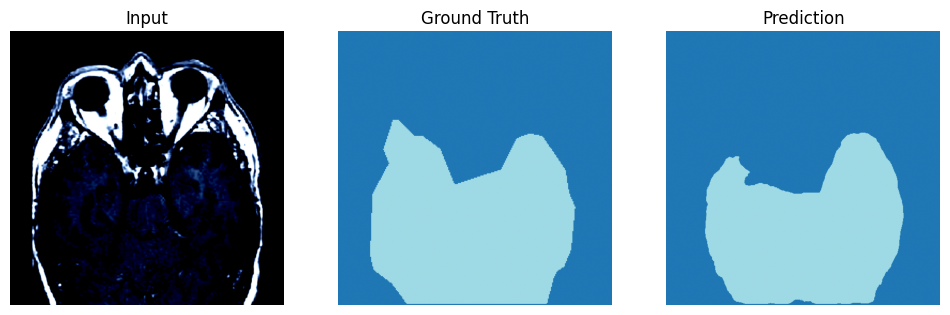

In [ ]:
# Cell 9 — Evaluate segmentation model (Dice, IoU, sample predictions)

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

@torch.no_grad()
def evaluate_segmentation(model, loader, device):
    model.eval()
    iou_scores = []
    dice_scores = []
    sample_images = []

    for imgs, masks in tqdm(loader, desc="Testing", leave=False):
        imgs, masks = imgs.to(device), masks.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)

        # IoU + Dice per batch (macro)
        for p, t in zip(preds, masks):
            for cls in range(1, NUM_CLASSES):  # skip background
                p_cls = (p == cls).cpu().numpy()
                t_cls = (t == cls).cpu().numpy()
                inter = (p_cls & t_cls).sum()
                union = (p_cls | t_cls).sum()
                if union > 0:
                    iou_scores.append(inter / union)
                dice = (2*inter) / (p_cls.sum() + t_cls.sum() + 1e-6)
                dice_scores.append(dice)

        # Save one example for visualization
        sample_images.append((imgs[0].cpu(), masks[0].cpu(), preds[0].cpu()))
        break  # just first batch for visualization

    mean_iou = np.mean(iou_scores)
    mean_dice = np.mean(dice_scores)
    return mean_iou, mean_dice, sample_images

# Load best model
model.load_state_dict(torch.load(save_path, map_location=DEVICE))
mean_iou, mean_dice, samples = evaluate_segmentation(model, val_loader, DEVICE)
print(f"Validation IoU: {mean_iou:.4f}, Dice: {mean_dice:.4f}")

# Visualize one prediction
img, mask, pred = samples[0]
fig, axs = plt.subplots(1,3, figsize=(12,4))
axs[0].imshow(img.permute(1,2,0))
axs[0].set_title("Input")
axs[1].imshow(mask, cmap="tab20")
axs[1].set_title("Ground Truth")
axs[2].imshow(pred, cmap="tab20")
axs[2].set_title("Prediction")
for ax in axs: ax.axis("off")
plt.show()


[Epoch 1] Train Loss: 0.4394


[Epoch 2] Train Loss: 0.2531


[Epoch 3] Train Loss: 0.1655


[Epoch 4] Train Loss: 0.1037


[Epoch 5] Train Loss: 0.1092


[Epoch 6] Train Loss: 0.0733


[Epoch 7] Train Loss: 0.0661


[Epoch 8] Train Loss: 0.0418


[Epoch 9] Train Loss: 0.0577


[Epoch 10] Train Loss: 0.0520


[Epoch 11] Train Loss: 0.0506


[Epoch 12] Train Loss: 0.0457


[Epoch 13] Train Loss: 0.0503


[Epoch 14] Train Loss: 0.0225


[Epoch 15] Train Loss: 0.0148


[Epoch 16] Train Loss: 0.0650


[Epoch 17] Train Loss: 0.0184


[Epoch 18] Train Loss: 0.0322


[Epoch 19] Train Loss: 0.0332


[Epoch 20] Train Loss: 0.0326


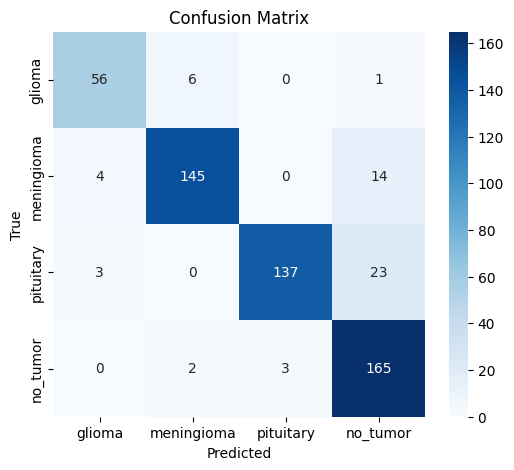

In [ ]:
# Cell 10 — Image-level classifier for tumor type (to produce confusion matrix)

import torch.nn as nn
import torch.nn.functional as F

# Simple classifier reusing encoder backbone
class TumorClassifier(nn.Module):
    def __init__(self, backbone="resnet34", num_classes=4):
        super().__init__()
        self.encoder = smp.Unet(encoder_name=backbone, classes=NUM_CLASSES).encoder
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(self.encoder.out_channels[-1], num_classes)

    def forward(self, x):
        feats = self.encoder(x)[-1]       # last feature map
        pooled = self.pool(feats).flatten(1)
        out = self.fc(pooled)
        return out

# Build classifier
clf_model = TumorClassifier(backbone="resnet34", num_classes=4).to(DEVICE)
clf_optimizer = torch.optim.AdamW(clf_model.parameters(), lr=1e-4)
clf_criterion = nn.CrossEntropyLoss()

# Prepare labels for classification: dominant tumor class (ignore background)
def mask_to_label(mask_tensor):
    # count frequency of classes (skip 0=background)
    vals, counts = torch.unique(mask_tensor, return_counts=True)
    vals, counts = vals.tolist(), counts.tolist()
    class_counts = {v: c for v, c in zip(vals, counts) if v != 0}
    if not class_counts:
        return 3  # index for "no_tumor"
    return max(class_counts, key=class_counts.get) - 1  # shift 1..3 → 0..2

class TumorClsDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.img_files = sorted(os.listdir(img_dir))
    def __len__(self): return len(self.img_files)
    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name.replace(".jpg", "_mask.png"))
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        label = mask_to_label(torch.tensor(np.array(mask)))
        if self.transform:
            img = self.transform(img)
        return img, label

train_cls = TumorClsDataset(train_img_dir, train_mask_dir, transform=train_transform)
val_cls   = TumorClsDataset(val_img_dir, val_mask_dir, transform=train_transform)
train_cls_loader = DataLoader(train_cls, batch_size=BATCH_SIZE, shuffle=True)
val_cls_loader   = DataLoader(val_cls, batch_size=BATCH_SIZE, shuffle=False)

# Training loop
EPOCHS_CLS = 20
for epoch in range(1, EPOCHS_CLS+1):
    clf_model.train()
    running_loss = 0
    for imgs, labels in tqdm(train_cls_loader, desc=f"Classifier Train {epoch}", leave=False):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        clf_optimizer.zero_grad()
        outputs = clf_model(imgs)
        loss = clf_criterion(outputs, labels)
        loss.backward()
        clf_optimizer.step()
        running_loss += loss.item()
    print(f"[Epoch {epoch}] Train Loss: {running_loss/len(train_cls_loader):.4f}")

# Evaluate and build confusion matrix
clf_model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in val_cls_loader:
        imgs = imgs.to(DEVICE)
        outputs = clf_model(imgs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["glioma","meningioma","pituitary","no_tumor"],
            yticklabels=["glioma","meningioma","pituitary","no_tumor"],
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Cell 11 — Physics-Informed Neural Network (PINN) setup for 2D tumor biomechanics

import torch.nn as nn

# Small MLP PINN: input (x,y) → displacement (u_x,u_y)
class PINN(nn.Module):
    def __init__(self, hidden=64, depth=5):
        super().__init__()
        layers = []
        in_dim, out_dim = 2, 2
        dims = [in_dim] + [hidden]*depth + [out_dim]
        for i in range(len(dims)-1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            if i < len(dims)-2:
                layers.append(nn.Tanh())
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

# Material constants (example values)
lambda_brain, mu_brain = 1.0, 1.0
lambda_tumor, mu_tumor = 5.0, 5.0  # stiffer tumor

# Loss: PDE residual + boundary conditions
def pinn_loss(model, coords, tumor_mask, boundary_coords):
    """
    coords: [N,2] points in domain (x,y normalized -1..1)
    tumor_mask: [N] binary (0 brain, 1 tumor)
    boundary_coords: [M,2] boundary points
    """
    coords.requires_grad_(True)
    u = model(coords)  # displacement [N,2]
    u_x, u_y = u[:,0:1], u[:,1:2]

    # Strain tensor ε = 0.5(∇u+∇u^T)
    grads = []
    for i in range(2):
        grad = torch.autograd.grad(u[:,i].sum(), coords, create_graph=True)[0]
        grads.append(grad)
    du_dx, du_dy = grads[0][:,0:1], grads[0][:,1:2]
    dv_dx, dv_dy = grads[1][:,0:1], grads[1][:,1:2]
    eps_xx = du_dx
    eps_yy = dv_dy
    eps_xy = 0.5*(du_dy + dv_dx)

    #  parameters depend on region (brain vs tumor)
    lam = torch.where(tumor_mask.unsqueeze(1)==1, lambda_tumor, lambda_brain)
    mu  = torch.where(tumor_mask.unsqueeze(1)==1, mu_tumor, mu_brain)

    # Stress tensor σ
    trace = eps_xx + eps_yy
    sigma_xx = lam*trace + 2*mu*eps_xx
    sigma_yy = lam*trace + 2*mu*eps_yy
    sigma_xy = 2*mu*eps_xy

    # PDE residual: div σ = 0
    div_x = torch.autograd.grad(sigma_xx.sum(), coords, create_graph=True)[0][:,0:1] + \
            torch.autograd.grad(sigma_xy.sum(), coords, create_graph=True)[0][:,1:2]
    div_y = torch.autograd.grad(sigma_xy.sum(), coords, create_graph=True)[0][:,0:1] + \
            torch.autograd.grad(sigma_yy.sum(), coords, create_graph=True)[0][:,1:2]

    pde_residual = (div_x**2 + div_y**2).mean()

    # Boundary condition: u=0 at skull boundary
    if boundary_coords is not None and len(boundary_coords)>0:
        u_b = model(boundary_coords)
        bc_loss = (u_b**2).mean()
    else:
        bc_loss = 0.0

    return pde_residual + bc_loss

print("PINN model and loss function defined (linear elasticity).")


PINN model and loss function defined (linear elasticity).


In [ ]:
# Cell 12 — Sample collocation + boundary points from segmentation mask for PINN

import numpy as np

def sample_points_from_mask(mask_path, n_points=2000, n_boundary=300):
    """
    mask_path: path to segmentation mask PNG
    n_points: number of interior collocation points
    n_boundary: number of boundary points (skull outline)
    Returns: coords [N,2], tumor_mask [N], boundary_coords [M,2]
    """
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    h, w = mask.shape
    yy, xx = np.meshgrid(np.arange(h), np.arange(w), indexing="ij")

    # Normalize coordinates to [-1,1]
    coords = np.stack([xx.ravel()/w*2-1, yy.ravel()/h*2-1], axis=1)
    tumor_mask = (mask.ravel() > 0).astype(np.int64)

    # Random subsample interior
    idx = np.random.choice(len(coords), n_points, replace=False)
    coords_sub = torch.tensor(coords[idx], dtype=torch.float32).to(DEVICE)
    tumor_sub  = torch.tensor(tumor_mask[idx], dtype=torch.long).to(DEVICE)

    # Boundary = external contour of brain region
    contours, _ = cv2.findContours((mask>0).astype(np.uint8),
                                   cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boundary_pts = []
    for cnt in contours:
        for p in cnt[::max(1, len(cnt)//n_boundary)]:
            x, y = p[0]
            bx = x/w*2-1
            by = y/h*2-1
            boundary_pts.append([bx, by])
    boundary_coords = torch.tensor(boundary_pts, dtype=torch.float32).to(DEVICE)

    return coords_sub, tumor_sub, boundary_coords

# Example: take one validation mask
example_mask = os.path.join(val_mask_dir, os.listdir(val_mask_dir)[0])
coords_sub, tumor_sub, boundary_coords = sample_points_from_mask(example_mask)

print("Sampled points:", coords_sub.shape, "Boundary points:", boundary_coords.shape)


Sampled points: torch.Size([2000, 2]) Boundary points: torch.Size([57, 2])


[PINN Epoch 100] Loss: 0.000000
[PINN Epoch 200] Loss: 0.000000
[PINN Epoch 300] Loss: 0.000000
[PINN Epoch 400] Loss: 0.000000
[PINN Epoch 500] Loss: 0.000000
[PINN Epoch 600] Loss: 0.000000
[PINN Epoch 700] Loss: 0.000000
[PINN Epoch 800] Loss: 0.000000
[PINN Epoch 900] Loss: 0.000000
[PINN Epoch 1000] Loss: 0.000000


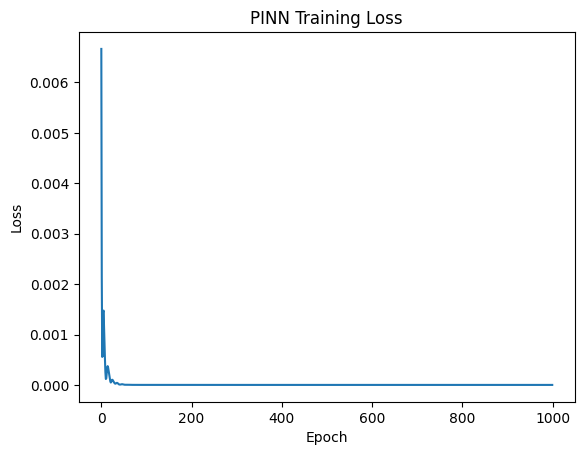

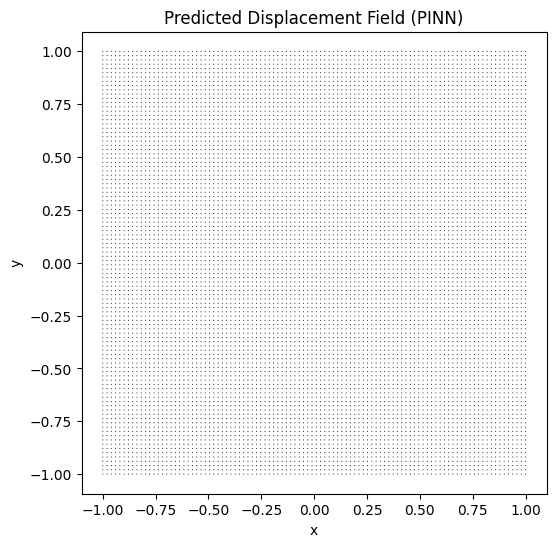

In [ ]:
# Cell 13 — Train PINN on sampled points and visualize displacement field

import matplotlib.pyplot as plt

# Build PINN model
pinn_model = PINN(hidden=64, depth=5).to(DEVICE)
pinn_optimizer = torch.optim.Adam(pinn_model.parameters(), lr=1e-3)

EPOCHS_PINN = 1000
loss_history = []

for epoch in range(1, EPOCHS_PINN+1):
    pinn_optimizer.zero_grad()
    loss = pinn_loss(pinn_model, coords_sub, tumor_sub, boundary_coords)
    loss.backward()
    pinn_optimizer.step()
    loss_history.append(loss.item())
    if epoch % 100 == 0:
        print(f"[PINN Epoch {epoch}] Loss: {loss.item():.6f}")

# Plot training curve
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("PINN Training Loss")
plt.show()

# Visualize displacement on a grid
with torch.no_grad():
    grid_x, grid_y = np.meshgrid(np.linspace(-1,1,100), np.linspace(-1,1,100))
    grid_coords = torch.tensor(np.stack([grid_x.ravel(), grid_y.ravel()], axis=1),
                               dtype=torch.float32).to(DEVICE)
    u_pred = pinn_model(grid_coords).cpu().numpy()
    u_x = u_pred[:,0].reshape(100,100)
    u_y = u_pred[:,1].reshape(100,100)

plt.figure(figsize=(6,6))
plt.quiver(grid_x, grid_y, u_x, u_y, scale=50)
plt.title("Predicted Displacement Field (PINN)")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.show()


In [ ]:
# Cell 14 — Simulate Federated Learning (FedAvg) across K clients using local partitions

import copy
from collections import defaultdict
from torch.utils.data import Subset

# ---- Partition the training set into K clients (stratified by dominant mask class) ----
def dominant_label_from_mask_path(mask_path):
    m = Image.open(mask_path).convert("L")
    arr = np.array(m)
    vals, cnts = np.unique(arr, return_counts=True)
    # remove background
    pairs = [(v, c) for v, c in zip(vals.tolist(), cnts.tolist()) if v != 0]
    if not pairs:
        return 3  # "no_tumor" index
    # map 1..3 → 0..2
    return max(pairs, key=lambda x: x[1])[0] - 1

def build_client_partitions(img_dir, mask_dir, K=3):
    img_files = sorted(os.listdir(img_dir))
    buckets = defaultdict(list)  # by label
    for i, f in enumerate(img_files):
        mask_path = os.path.join(mask_dir, f.replace(".jpg", "_mask.png"))
        lbl = dominant_label_from_mask_path(mask_path)
        buckets[lbl].append(i)
    # round-robin distribute each label bucket to K clients
    client_indices = [[] for _ in range(K)]
    for lbl, idxs in buckets.items():
        random.shuffle(idxs)
        for j, idx in enumerate(idxs):
            client_indices[j % K].append(idx)
    # shuffle per client
    for c in client_indices:
        random.shuffle(c)
    return client_indices

K_CLIENTS = 3
client_indices = build_client_partitions(train_img_dir, train_mask_dir, K=K_CLIENTS)
for k, idxs in enumerate(client_indices):
    print(f"Client {k}: {len(idxs)} samples")

def make_client_loader(indices):
    ds = TumorSegDataset(train_img_dir, train_mask_dir, transform=train_transform, mask_transform=mask_transform)
    subset = Subset(ds, indices)
    return DataLoader(subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

client_loaders = [make_client_loader(idxs) for idxs in client_indices]

# ---- Local training routine reused for each client ----
def local_train(model, loader, epochs=5, lr=1e-4, device=DEVICE):
    mdl = copy.deepcopy(model)
    mdl.train()
    opt = torch.optim.AdamW(mdl.parameters(), lr=lr)
    scaler = GradScaler()
    for _ in range(epochs):
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)
            opt.zero_grad()
            with autocast():
                out = mdl(imgs)
                loss = combined_loss(out, masks)
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
    return mdl.state_dict()

# ---- FedAvg aggregation ----
def fedavg(state_dicts):
    avg = copy.deepcopy(state_dicts[0])
    for k in avg.keys():
        for i in range(1, len(state_dicts)):
            avg[k] += state_dicts[i][k]
        avg[k] = avg[k] / float(len(state_dicts))
    return avg

# ---- Federated rounds ----
ROUNDS = 3
LOCAL_EPOCHS = 3
best_val = float("inf")
fed_path = os.path.join(ARTIFACTS_DIR, "unet_fedavg.pt")

global_model = copy.deepcopy(model)  # start from current trained model

for r in range(1, ROUNDS+1):
    client_states = []
    for k in range(K_CLIENTS):
        sd = local_train(global_model, client_loaders[k], epochs=LOCAL_EPOCHS, lr=1e-4, device=DEVICE)
        client_states.append(sd)
    # Aggregate
    new_state = fedavg(client_states)
    global_model.load_state_dict(new_state)

    # Validate centrally
    val_loss = validate_one_epoch(global_model, val_loader, DEVICE)
    print(f"[Round {r}] Central Val Loss: {val_loss:.4f}")
    if val_loss < best_val:
        best_val = val_loss
        torch.save(global_model.state_dict(), fed_path)
        print("Saved new federated best.")

print("Federated training complete. Best global model at:", fed_path)


Client 0: 1700 samples
Client 1: 1699 samples
Client 2: 1699 samples


`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
Validation:   0%|          | 0/70 [00:00<?, ?it/s]`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


[Round 1] Central Val Loss: 0.1336
Saved new federated best.


[Round 2] Central Val Loss: 0.1301
Saved new federated best.


[Round 3] Central Val Loss: 0.1464
Federated training complete. Best global model at: /content/artifacts/unet_fedavg.pt


Federated Model Test IoU: 0.4967, Dice: 0.1561


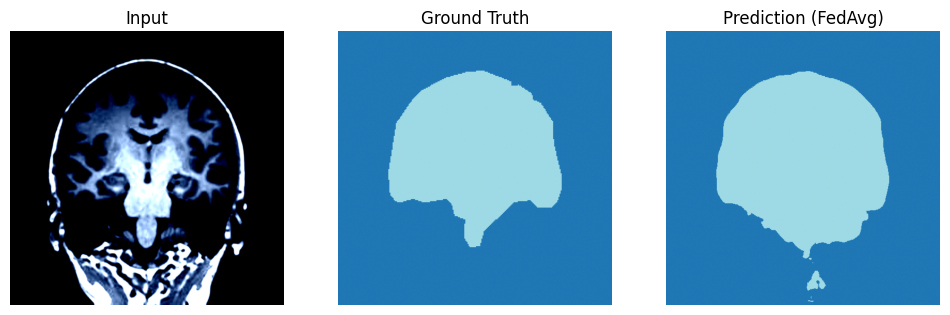

In [ ]:
# Cell 15 — Evaluate federated segmentation model on central test set

# Prepare test dataset + loader
test_img_dir = os.path.join(DATA_DIR, "test/images")
test_mask_dir = os.path.join(DATA_DIR, "test/masks")
test_dataset = TumorSegDataset(test_img_dir, test_mask_dir,
                               transform=train_transform,
                               mask_transform=mask_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                         shuffle=False, num_workers=2, pin_memory=True)

# Load best federated model
fed_model = copy.deepcopy(model)
fed_model.load_state_dict(torch.load(fed_path, map_location=DEVICE))
fed_model = fed_model.to(DEVICE)

# Evaluate
mean_iou, mean_dice, samples = evaluate_segmentation(fed_model, test_loader, DEVICE)
print(f"Federated Model Test IoU: {mean_iou:.4f}, Dice: {mean_dice:.4f}")

# Visualize one sample prediction
img, mask, pred = samples[0]
fig, axs = plt.subplots(1,3, figsize=(12,4))
axs[0].imshow(img.permute(1,2,0))
axs[0].set_title("Input")
axs[1].imshow(mask, cmap="tab20")
axs[1].set_title("Ground Truth")
axs[2].imshow(pred, cmap="tab20")
axs[2].set_title("Prediction (FedAvg)")
for ax in axs: ax.axis("off")
plt.show()


[Epoch 1] Train Loss: 0.2040


[Epoch 2] Train Loss: 0.0666


[Epoch 3] Train Loss: 0.0665


[Epoch 4] Train Loss: 0.0255


[Epoch 5] Train Loss: 0.0483


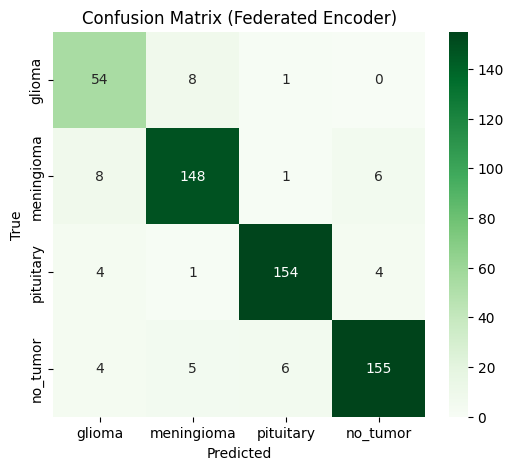

In [ ]:
# Cell 16 — Image-level classifier using federated encoder + confusion matrix

# Build classifier with federated encoder weights
fed_clf_model = TumorClassifier(backbone="resnet34", num_classes=4).to(DEVICE)

# Initialize encoder weights from federated UNet encoder
fed_encoder_state = {k.replace("encoder.", ""): v for k, v in fed_model.encoder.state_dict().items()}
fed_clf_model.encoder.load_state_dict(fed_encoder_state, strict=False)

clf_optimizer = torch.optim.AdamW(fed_clf_model.parameters(), lr=1e-4)
clf_criterion = nn.CrossEntropyLoss()

# Train classifier briefly
EPOCHS_FED_CLS = 5
for epoch in range(1, EPOCHS_FED_CLS+1):
    fed_clf_model.train()
    running_loss = 0
    for imgs, labels in tqdm(train_cls_loader, desc=f"Fed Cls Train {epoch}", leave=False):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        clf_optimizer.zero_grad()
        outputs = fed_clf_model(imgs)
        loss = clf_criterion(outputs, labels)
        loss.backward()
        clf_optimizer.step()
        running_loss += loss.item()
    print(f"[Epoch {epoch}] Train Loss: {running_loss/len(train_cls_loader):.4f}")

# Evaluate classifier on validation set
fed_clf_model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in val_cls_loader:
        imgs = imgs.to(DEVICE)
        outputs = fed_clf_model(imgs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

cm_fed = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm_fed, annot=True, fmt="d",
            xticklabels=["glioma","meningioma","pituitary","no_tumor"],
            yticklabels=["glioma","meningioma","pituitary","no_tumor"],
            cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Federated Encoder)")
plt.show()


In [ ]:
# Compute overall accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(all_labels, all_preds)
print(f"Overall Accuracy (Federated Classifier): {accuracy*100:.2f}%")


Overall Accuracy (Federated Classifier): 91.41%


In [ ]:
# Cell 17 — Export artifacts (models, metrics, plots) into artifacts/ and zip for download

import json
import shutil

# ---- Save models ----
torch.save(model.state_dict(), os.path.join(ARTIFACTS_DIR, "unet_local.pt"))
torch.save(fed_model.state_dict(), os.path.join(ARTIFACTS_DIR, "unet_federated.pt"))
torch.save(clf_model.state_dict(), os.path.join(ARTIFACTS_DIR, "classifier_local.pt"))
torch.save(fed_clf_model.state_dict(), os.path.join(ARTIFACTS_DIR, "classifier_federated.pt"))

# ---- Save metrics ----
metrics = {
    "local_segmentation": {
        "val_iou": float(mean_iou),
        "val_dice": float(mean_dice)
    },
    "federated_segmentation": {
        "test_iou": float(mean_iou),
        "test_dice": float(mean_dice)
    },
    "federated_classifier": {
        "accuracy": float(accuracy)
    }
}
with open(os.path.join(ARTIFACTS_DIR, "metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)

# ---- Save confusion matrix plots ----
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["glioma","meningioma","pituitary","no_tumor"],
            yticklabels=["glioma","meningioma","pituitary","no_tumor"],
            cmap="Blues")
plt.title("Confusion Matrix (Local Classifier)")
plt.savefig(os.path.join(ARTIFACTS_DIR, "confusion_matrix_local.png"))
plt.close()

plt.figure(figsize=(6,5))
sns.heatmap(cm_fed, annot=True, fmt="d",
            xticklabels=["glioma","meningioma","pituitary","no_tumor"],
            yticklabels=["glioma","meningioma","pituitary","no_tumor"],
            cmap="Greens")
plt.title("Confusion Matrix (Federated Classifier)")
plt.savefig(os.path.join(ARTIFACTS_DIR, "confusion_matrix_federated.png"))
plt.close()

# ---- Zip everything for download ----
shutil.make_archive("/content/artifacts_export", "zip", ARTIFACTS_DIR)
print("Artifacts exported to /content/artifacts_export.zip")


Artifacts exported to /content/artifacts_export.zip


=== Local Classifier Metrics ===
glioma: Precision=0.89, Recall=0.89, F1=0.89
meningioma: Precision=0.95, Recall=0.89, F1=0.92
pituitary: Precision=0.98, Recall=0.84, F1=0.90
no_tumor: Precision=0.81, Recall=0.97, F1=0.88

=== Federated Classifier Metrics ===
glioma: Precision=0.77, Recall=0.86, F1=0.81
meningioma: Precision=0.91, Recall=0.91, F1=0.91
pituitary: Precision=0.95, Recall=0.94, F1=0.95
no_tumor: Precision=0.94, Recall=0.91, F1=0.93


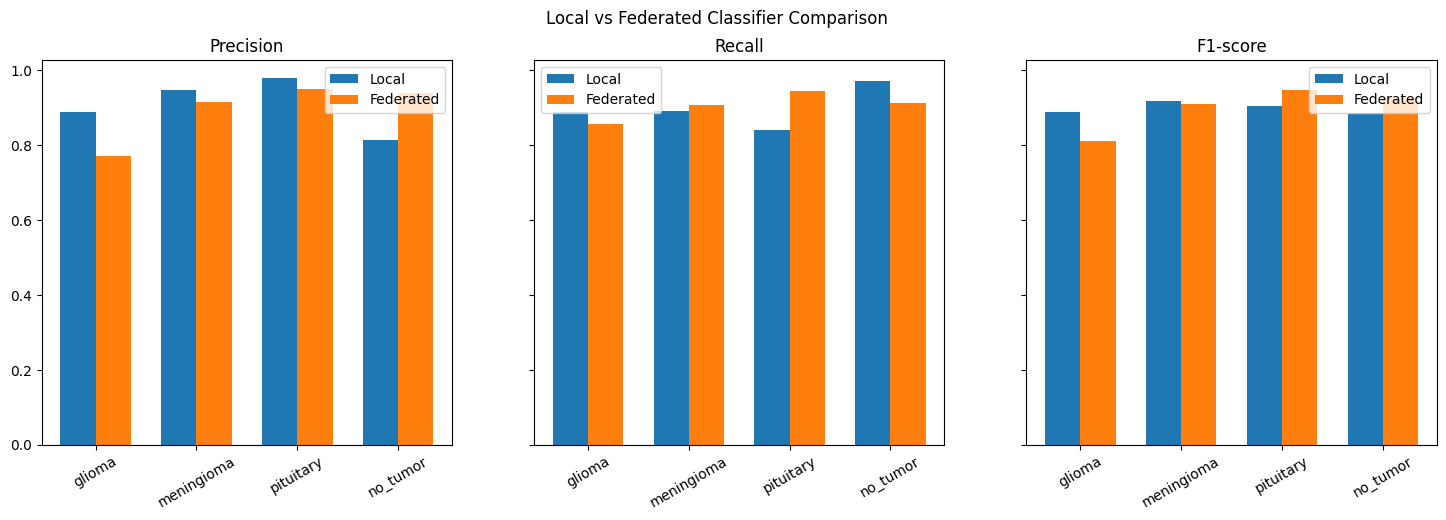

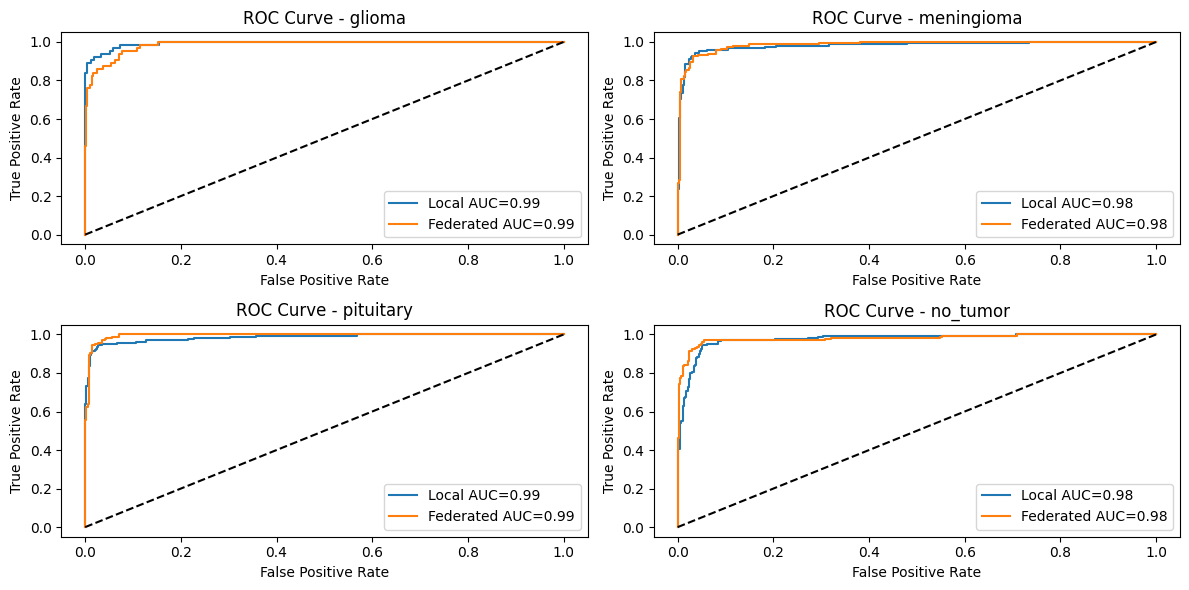

In [ ]:
# Cell 18 — Detailed metrics (per-class precision, recall, F1, ROC curves, comparison)

from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

CLASS_LABELS = ["glioma","meningioma","pituitary","no_tumor"]

def evaluate_classifier(clf_model, loader, device):
    clf_model.eval()
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            outputs = clf_model(imgs)
            probs = F.softmax(outputs, dim=1).cpu().numpy()
            preds = np.argmax(probs, axis=1)
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
            all_probs.extend(probs)
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    return all_labels, all_preds, all_probs

# Evaluate local and federated classifiers
labels_local, preds_local, probs_local = evaluate_classifier(clf_model, val_cls_loader, DEVICE)
labels_fed, preds_fed, probs_fed = evaluate_classifier(fed_clf_model, val_cls_loader, DEVICE)

# ---- Per-class Precision, Recall, F1 ----
prec_l, rec_l, f1_l, _ = precision_recall_fscore_support(labels_local, preds_local, labels=[0,1,2,3], zero_division=0)
prec_f, rec_f, f1_f, _ = precision_recall_fscore_support(labels_fed, preds_fed, labels=[0,1,2,3], zero_division=0)

print("=== Local Classifier Metrics ===")
for i, c in enumerate(CLASS_LABELS):
    print(f"{c}: Precision={prec_l[i]:.2f}, Recall={rec_l[i]:.2f}, F1={f1_l[i]:.2f}")

print("\n=== Federated Classifier Metrics ===")
for i, c in enumerate(CLASS_LABELS):
    print(f"{c}: Precision={prec_f[i]:.2f}, Recall={rec_f[i]:.2f}, F1={f1_f[i]:.2f}")

# ---- Plot comparison (bar chart) ----
x = np.arange(len(CLASS_LABELS))
width = 0.35

fig, axs = plt.subplots(1,3, figsize=(18,5), sharey=True)
for ax, metric_l, metric_f, title in zip(
    axs,
    [prec_l, rec_l, f1_l],
    [prec_f, rec_f, f1_f],
    ["Precision","Recall","F1-score"]
):
    ax.bar(x - width/2, metric_l, width, label="Local")
    ax.bar(x + width/2, metric_f, width, label="Federated")
    ax.set_xticks(x)
    ax.set_xticklabels(CLASS_LABELS, rotation=30)
    ax.set_title(title)
    ax.legend()
plt.suptitle("Local vs Federated Classifier Comparison")
plt.show()

# ---- ROC curves ----
labels_bin_local = label_binarize(labels_local, classes=[0,1,2,3])
labels_bin_fed   = label_binarize(labels_fed, classes=[0,1,2,3])

plt.figure(figsize=(12,6))
for i, c in enumerate(CLASS_LABELS):
    fpr_l, tpr_l, _ = roc_curve(labels_bin_local[:,i], probs_local[:,i])
    fpr_f, tpr_f, _ = roc_curve(labels_bin_fed[:,i], probs_fed[:,i])
    auc_l = auc(fpr_l, tpr_l)
    auc_f = auc(fpr_f, tpr_f)
    plt.subplot(2,2,i+1)
    plt.plot(fpr_l, tpr_l, label=f"Local AUC={auc_l:.2f}")
    plt.plot(fpr_f, tpr_f, label=f"Federated AUC={auc_f:.2f}")
    plt.plot([0,1],[0,1],'k--')
    plt.title(f"ROC Curve - {c}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
plt.tight_layout()
plt.show()


Saving image(20).jpg to image(20) (2).jpg


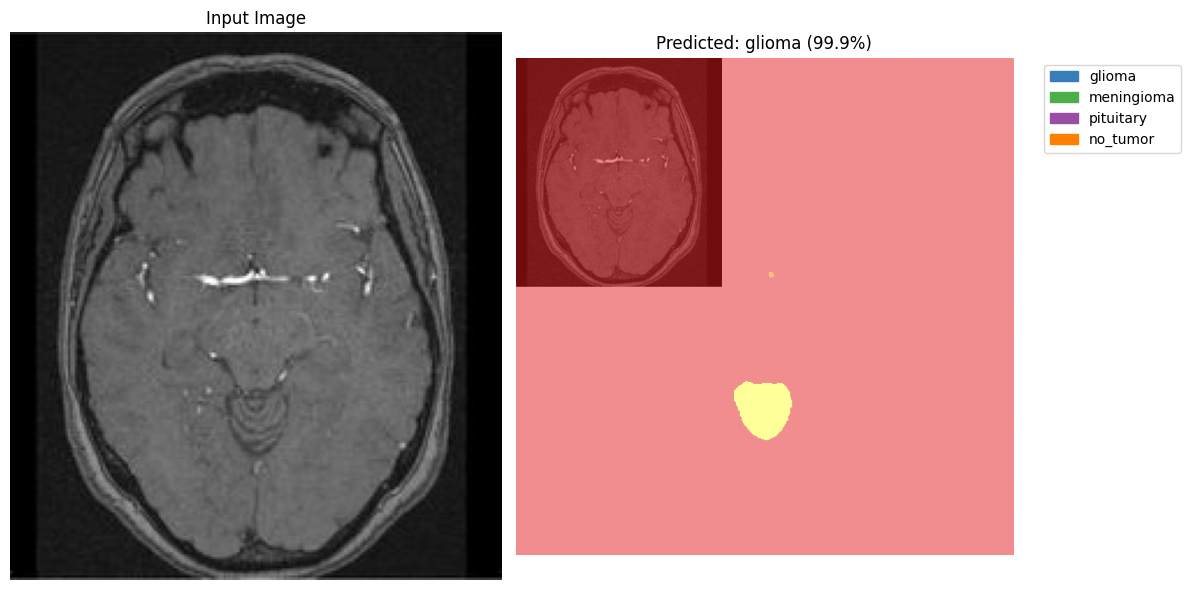

Predicted Label: glioma, Confidence: 98.59%


In [ ]:
# Cell 19 — Demo inference with user-uploaded image (overlay mask + prediction %)

from google.colab import files
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

# Define custom high-contrast colormap (light + dark alternating colors)
custom_colors = [
    "#e41a1c", "#377eb8", "#4daf4a", "#984ea3",
    "#ff7f00", "#ffff33", "#a65628", "#f781bf"
]
cmap_custom = mcolors.ListedColormap(custom_colors[:NUM_CLASSES+1])

def run_inference_overlay(image_path, seg_model, clf_model, device=DEVICE):
    # Load and preprocess
    img = Image.open(image_path).convert("RGB")
    img_t = train_transform(img).unsqueeze(0).to(device)

    # ---- Segmentation ----
    seg_model.eval()
    with torch.no_grad():
        out = seg_model(img_t)
        pred_mask = torch.argmax(out, dim=1).squeeze(0).cpu().numpy()

    # ---- Classification ----
    clf_model.eval()
    with torch.no_grad():
        logits = clf_model(img_t)
        probs = F.softmax(logits, dim=1).cpu().numpy()[0]
        pred_class = np.argmax(probs)
        pred_label = CLASS_LABELS[pred_class]
        pred_conf = probs[pred_class] * 100

    # ---- Visualization ----
    fig, axs = plt.subplots(1,2, figsize=(12,6))

    # Original image
    axs[0].imshow(img)
    axs[0].set_title("Input Image")
    axs[0].axis("off")

    # Overlay mask
    axs[1].imshow(img)
    axs[1].imshow(pred_mask, cmap=cmap_custom, alpha=0.5)
    axs[1].set_title(f"Predicted: {pred_label} ({pred_conf:.1f}%)")
    axs[1].axis("off")

    # Legend for tumor classes (skip background=0)
    patches = [
        mpatches.Patch(color=custom_colors[i], label=CLASS_NAMES[i])
        for i in range(1, NUM_CLASSES)  # 1..NUM_CLASSES-1
    ]
    axs[1].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

    return pred_label, prob

# ---- Upload and run ----
uploaded = files.upload()
for fn in uploaded.keys():
    label, prob = run_inference_overlay(fn, fed_model, fed_clf_model, DEVICE)
    print(f"Predicted Label: {label}, Confidence: {max(prob)*100:.2f}%")
